# Air Quality Sensor Results

My wife has suffered from moderate to severe eczema in her adult life, but it became nearly  debilitating several months after moving into a new apartment.  We suspect that indoor air quality, potentially from the boiler room or from the carpet, was contributing.  In the course of pursuing other options, we set up a number of air-quality sensors to record over time.  This shows the main results.  Total voltatile organic compounds were detected in different concentrations that varied substantially over time.  A dedicated formaldehyde sensor similarly had time varying signals.  Opening a window caused such signals to drop precipitously, showing the impact of open ventiliation.  

All air sensors interfaced with an Arduino Uno. 

SGP30: an air quality sensor; breakout board by Adafruit
 
SI7021: Humidity and temperature sensor; breakout board by Adafruit.
  
Gravity: Formaldehyde (HCHO) sensor, breakout board by DFRobot; sensor unknown.

MQ-X: a suite of eight different air sensors.   

The SPG30 and Si7021 sensors communicate over I2C; the Gravity
sensor uses UART communication on a single digital pin
(facilitated by SoftwareSerial package).

The MQ sensors are analog output. In order to read all eight
simultaneously, they are digitized by a MCP3008 chip.  

Data was collected between May 28 and July 30, 2019.  On July 31, we moved apartments

In [1]:
import numpy as np
import pandas as pd
import SuitePanda
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import datetime
plt.rcParams['figure.figsize'] = [15, 8]

In [2]:
import importlib
importlib.reload(SuitePanda)

/home/rory/Arduino/python/SuitePanda2.py:76: UserWarning: registration of accessor <class 'SuitePanda2.suite'> under name 'suite' for type <class 'pandas.core.frame.DataFrame'> is overriding a preexisting attribute with the same name.
  class suite(object):


<module 'SuitePanda2' from '/home/rory/Arduino/python/SuitePanda2.py'>

In [3]:
import os
import subprocess
findfiles = subprocess.run(['ls /home/rory/Arduino/python/archive/suite*'],
                            stdout=subprocess.PIPE,
                            shell=True)
fullpaths = findfiles.stdout.decode('utf-8').split('\n')
files = [fullpath.split('python/')[1] for fullpath in fullpaths[0:-2]]
files

['archive/suite20190528.txt',
 'archive/suite20190529.txt',
 'archive/suite20190530.txt',
 'archive/suite20190602.txt',
 'archive/suite20190603.txt',
 'archive/suite20190604.txt',
 'archive/suite20190605.txt',
 'archive/suite20190607.txt',
 'archive/suite20190620.txt',
 'archive/suite20190621.txt',
 'archive/suite20190623.txt',
 'archive/suite20190624.txt',
 'archive/suite20190710.txt',
 'archive/suite20190711.txt',
 'archive/suite20190715.txt',
 'archive/suite20190717.txt',
 'archive/suite20190723.txt',
 'archive/suite20190724.txt',
 'archive/suite20190725.txt',
 'archive/suite20190726.txt',
 'archive/suite20190727.txt',
 'archive/suite20190728outside.txt',
 'archive/suite20190730.txt']

In [4]:
SweetPanda = SuitePanda.fileload(files[0])
for file in files[1:-1]:
    SweetPanda = SweetPanda.append(SuitePanda.fileload(file))
    

There is a bit of data cleanup to do here.  The first involves days on which the MCP3008 ADC was fried.  On such days, the MCP3008 usually returns zero values with occasional values up to the full-scale value (5V).  This can be seen by plotting.

Text(0, 0.5, 'ADC Output (V)')

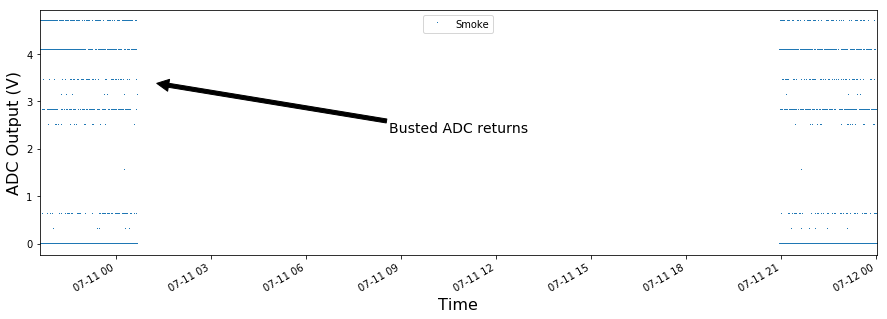

In [5]:
#Lesson in Pandas
#panda.loc['x'] searches for rows labelled 'x'
#apparently, it is quite smart.  Enter a day in MM/DD/YYYY format,
#and it picks out all data points from that day.  It also handles 'slicing'

#Plot 'Smoke' data from two days when ADC was busted
ax = SweetPanda.loc['07/10/2019':'07/12/2019'].plot(y='Smoke', 
                                                    style=',',
                                                    figsize=(15,5))
ax.annotate( 'Busted ADC returns', 
             xytext=(0.5,0.5),
             xy = (0.14,0.7),
             ha='center',
             xycoords='axes fraction',
             fontsize=14,
             arrowprops={'facecolor':'black'})
ax.set_xlabel('Time', fontsize=16)
ax.set_ylabel('ADC Output (V)', fontsize=16)

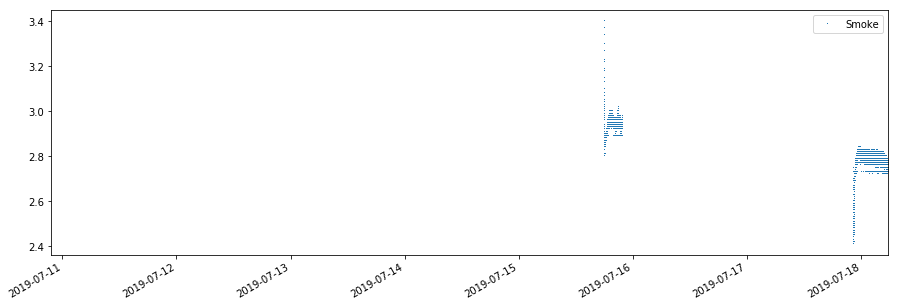

In [6]:
#Demonstrate clean-up 
SweetPanda.loc['07/10/2019':'07/12/2019', 'Smoke'] = np.nan
SweetPanda.loc['07/01/2019':'07/20/2019'].plot(y='Smoke', style=',', figsize=(15,5))

Text(0.46, 0.56, 'ADC busted')

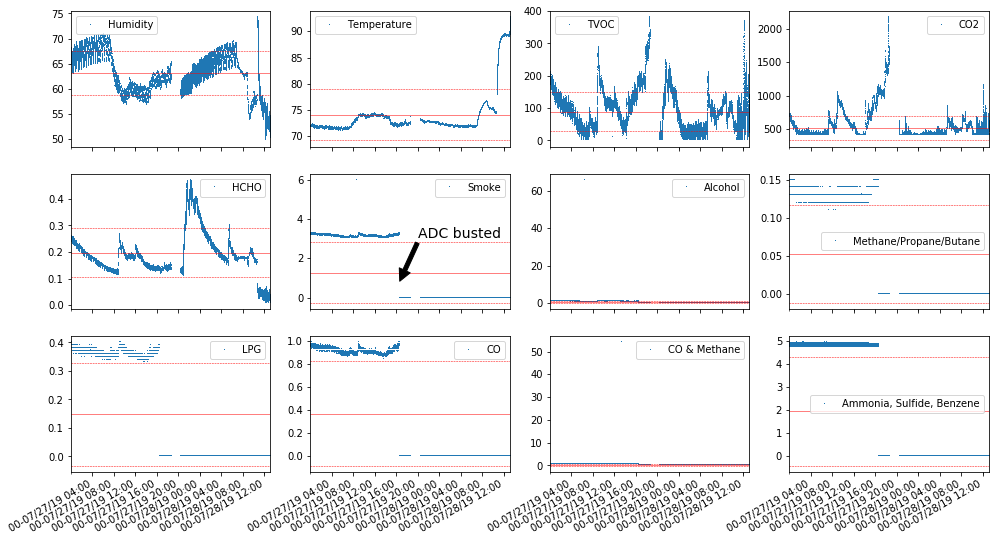

In [24]:
#Second ADC breakage on 07/27 in middle of run, shortly after 16:26, until the move out of 
#the Stonehill apartment on 07/31
SweetPanda.loc['07/27/2019':'07/31/2019'].suite.SuitePlot()
ThisAxis = plt.gca()
ThisAxis.annotate('ADC busted', 
                 xytext=(0.46,0.56),
                 xy = (0.40,0.48),
                 ha='center',
                 xycoords='figure fraction',
                 fontsize=14,
                 arrowprops={'facecolor':'black'})

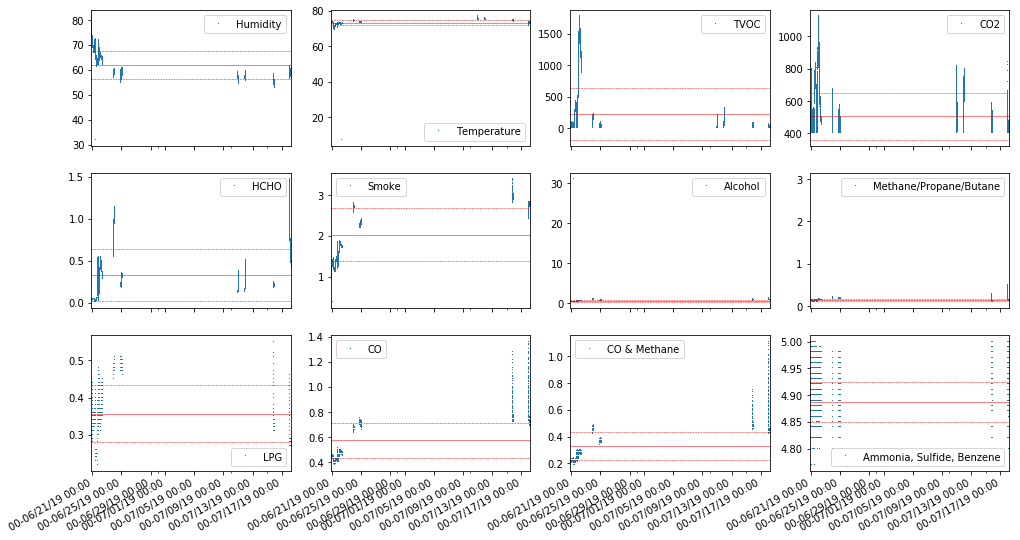

In [25]:
#Now fix all ADC channels for days on which ADC was busted
ADC_channel_names = ['Smoke', 'Alcohol', 'Methane/Propane/Butane', 'LPG', 
                     'CO', 'Hydrogen', 'CO & Methane', 'Ammonia, Sulfide, Benzene']
SweetPanda.loc['07/10/2019':'07/12/2019', ADC_channel_names] = np.nan
SweetPanda.loc['07/27/2019 16:25':'07/31/2019', ADC_channel_names] = np.nan
SweetPanda.loc['06/15/2019':'07/20/2019'].suite.SuitePlot()

In [54]:
SweetPanda.columns

Index(['Humidity', 'Temperature', 'TVOC', 'CO2', 'HCHO', 'Smoke', 'Alcohol',
       'Methane/Propane/Butane', 'LPG', 'CO', 'Hydrogen', 'CO & Methane',
       'Ammonia, Sulfide, Benzene'],
      dtype='object')

Second type of data clean-up: Arduino occasionally returns abnormally high values.  This happens infrequenly enough that it does not effect the quality of the data.  The most harmful effect is that Python rescales plots to reflect these spuriously high data points, compressing the view of the rest of the (viable) data.  The approach here is to specify a maximum value for each data set, determined by eye after inspecting plots, above which to remove data points.  

In [26]:
MaxVal = [100., 100., 100000., 10000., 10., 5., 5.,3.,5.,5.,5.,5.,5.]
for i,name in enumerate(SweetPanda.columns):
    SweetPanda.loc[SweetPanda[name] > MaxVal[i], name] = np.nan

/home/rory/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


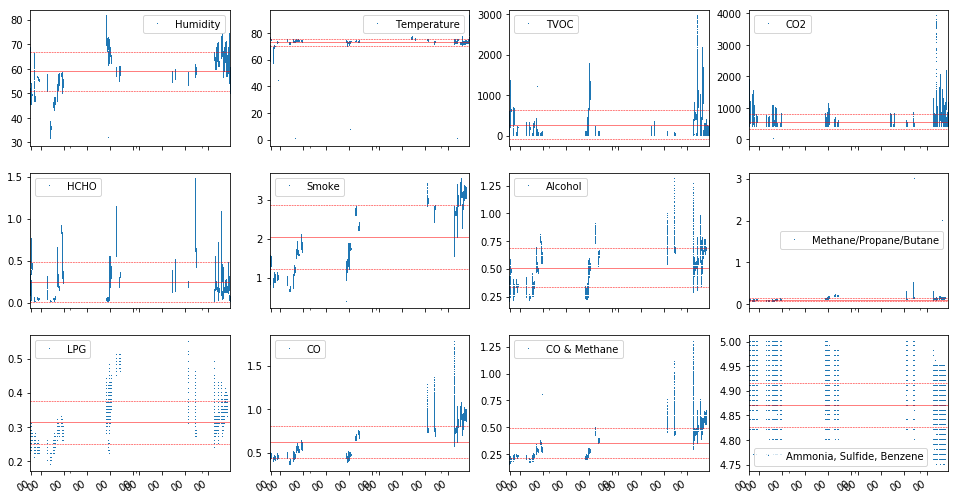

In [29]:
SweetPanda.suite.SuitePlot(format='%H')

In [30]:
SweetPanda.corr()

,Humidity,Temperature,TVOC,CO2,HCHO,Smoke,Alcohol,Methane/Propane/Butane,LPG,CO,Hydrogen,CO & Methane,"Ammonia, Sulfide, Benzene"
Humidity,1.000000,-0.157045,0.151196,0.033556,0.074168,0.516086,0.256880,0.572101,0.475307,0.467359,0.497830,0.486283,-0.327889
Temperature,-0.157045,1.000000,0.013166,-0.061215,0.103040,0.246851,0.292132,0.145931,0.166226,0.173429,0.103727,0.155302,-0.071042
TVOC,0.151196,0.013166,1.000000,0.628780,0.111520,0.207840,0.135419,0.136285,0.121807,0.166812,0.219765,0.196560,-0.186758
CO2,0.033556,-0.061215,0.628780,1.000000,0.147081,0.133084,0.146069,0.022466,0.054115,0.174824,0.192403,0.199859,-0.121376
HCHO,0.074168,0.103040,0.111520,0.147081,1.000000,0.433190,0.721465,0.512792,0.389783,0.333458,0.156560,0.380197,0.001179
Smoke,0.516086,0.246851,0.207840,0.133084,0.433190,1.000000,0.850413,0.621351,0.596287,0.965926,0.910589,0.970572,-0.449923
Alcohol,0.256880,0.292132,0.135419,0.146069,0.721465,0.850413,1.000000,0.625743,0.622527,0.798629,0.638567,0.823848,-0.268970
Methane/Propane/Butane,0.572101,0.145931,0.136285,0.022466,0.512792,0.621351,0.625743,1.000000,0.896740,0.536165,0.433769,0.561777,-0.221522
LPG,0.475307,0.166226,0.121807,0.054115,0.389783,0.596287,0.622527,0.896740,1.000000,0.548919,0.446322,0.551018,-0.241972
CO,0.467359,0.173429,0.166812,0.174824,0.333458,0.965926,0.798629,0.536165,0.548919,1.000000,0.962247,0.986166,-0.487493


From the giant correlation matrix above, the point of adding the MQ sensors was to determine what, if anything, was correlated with the TVOC and HCHO signals.  

The strongest correlation with TVOC was CO2, but this should be viewed with suspicion, as both measurements come from the same sensor.   TVOC was weakly correlated with a number of the MQ sensors, but the correlation in down around 0.2.

HCHO, on the otherhand, was well correlated with the 'Alcohol' MQ sensor (0.72) and also with Methane/Propane/Butane (0.51) and a number of other sensors at lower levels.  Interestingly, the TVOC and HCHO sensors were not well correlated 

In [34]:
subpanda = SweetPanda[ADC_channel_names]
M = subpanda.corr()

In [8]:
SweetPanda.columns

Index(['Humidity', 'Temperature', 'TVOC', 'CO2', 'HCHO', 'Smoke', 'Alcohol',
       'Methane/Propane/Butane', 'LPG', 'CO', 'Hydrogen', 'CO & Methane',
       'Ammonia, Sulfide, Benzene'],
      dtype='object')

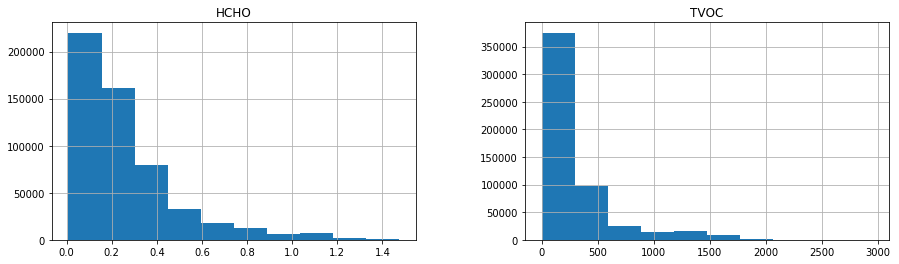

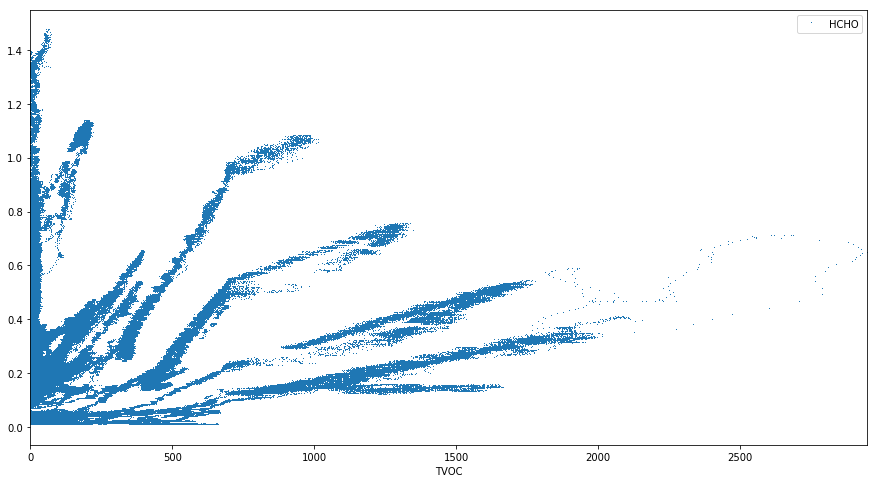

In [37]:
SweetPanda.hist(column=['TVOC','HCHO'],
               figsize=(15,4))
SweetPanda.plot(x='TVOC', y="HCHO", style=',')

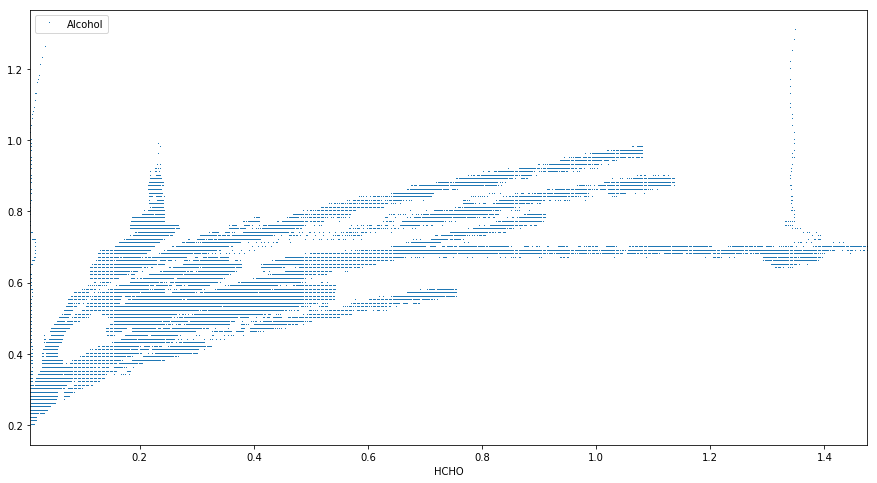

In [38]:
SweetPanda.plot(x='HCHO', y='Alcohol', style=',')

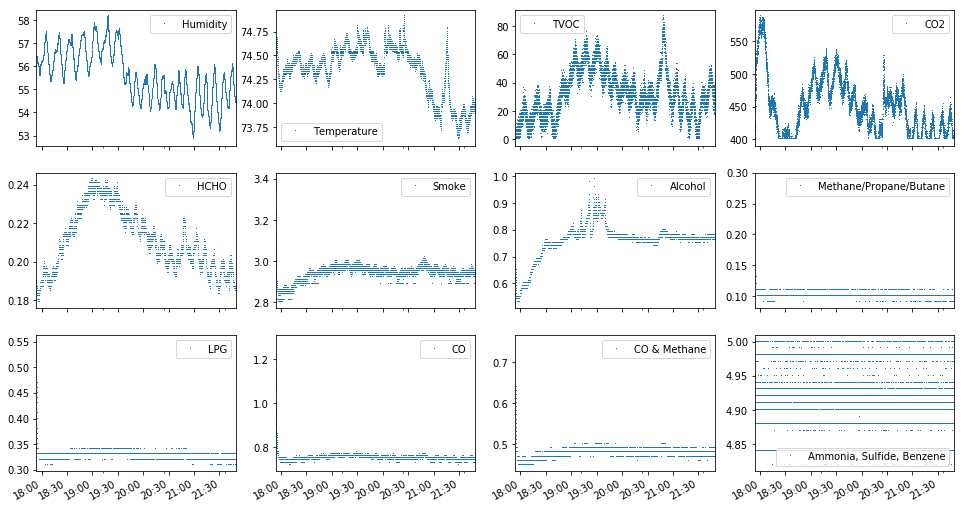

In [14]:
jul15 = SuitePanda.fileload('archive/suite20190715.txt')
jul15.suite.SuitePlot()

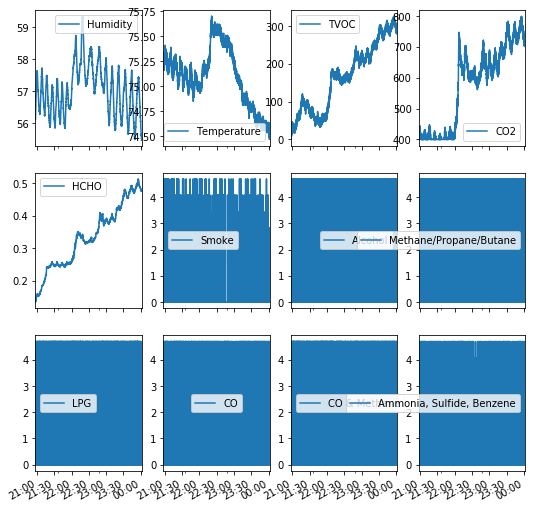

In [21]:
jul11 = SuitePanda.fileload('archive/suite20190711.txt')
jul11.suite.SuitePlot()

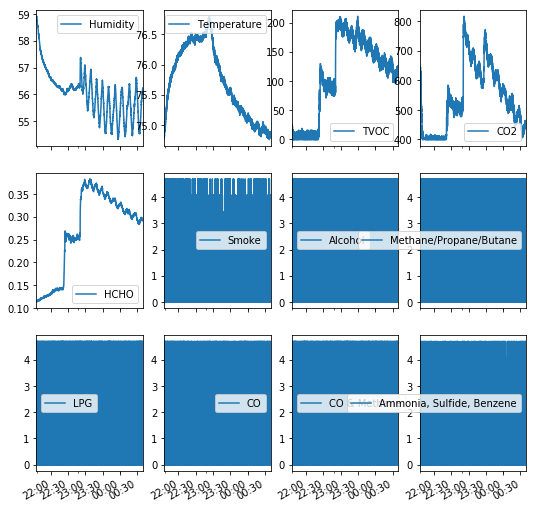

In [22]:
jul10 = SuitePanda.fileload('archive/suite20190710.txt')
jul10.suite.SuitePlot()

In [31]:
midjune = SuitePanda.fileload('archive/suite20190620.txt')
midjune = midjune.append(SuitePanda.fileload('archive/suite20190621.txt'))
midjune = midjune.append(SuitePanda.fileload('archive/suite20190623.txt'))
midjune = midjune.append(SuitePanda.fileload('archive/suite20190624.txt'))

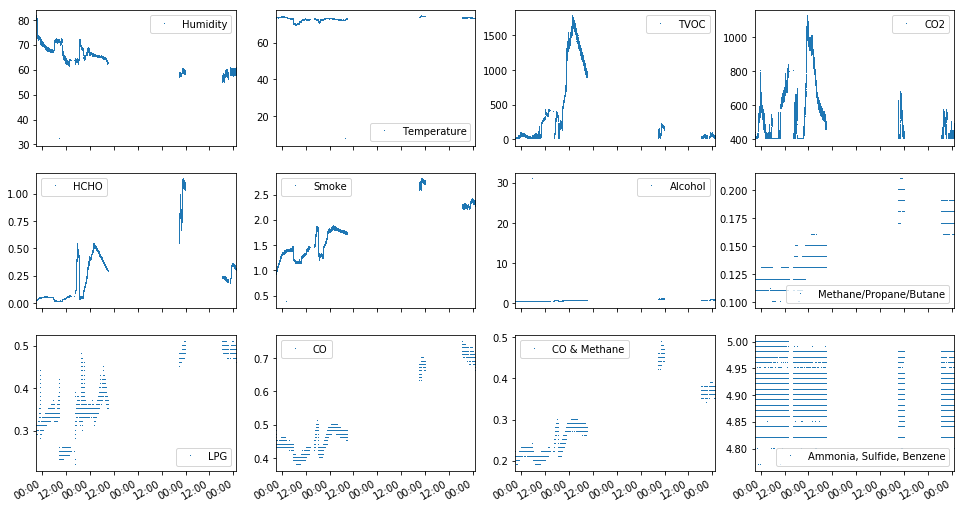

In [22]:
midjune.suite.SuitePlot()

In [28]:
earlyjune = SuitePanda.fileload('archive/suite20190602.txt')
for day in ['3','4','5','7']:
    earlyjune = earlyjune.append(SuitePanda.fileload('archive/suite2019060'+day+'.txt'))


/home/rory/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


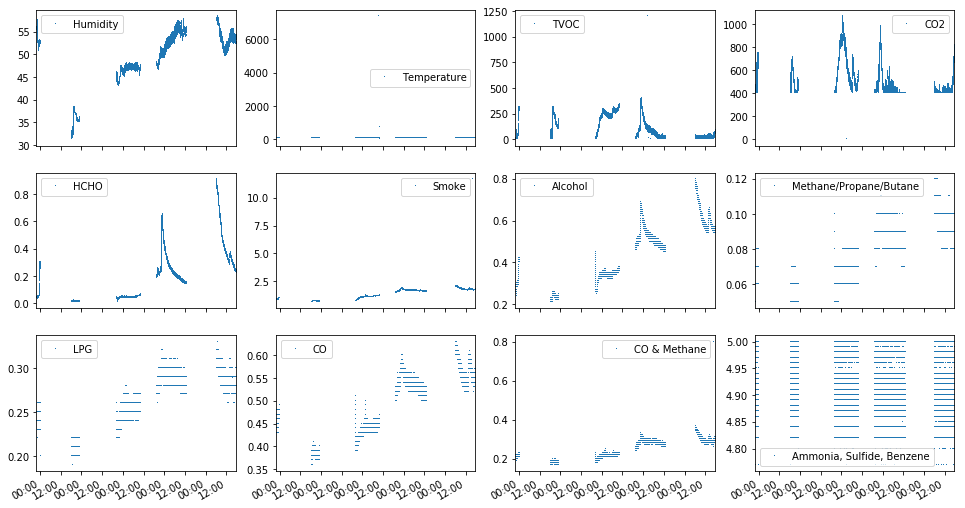

In [29]:
earlyjune.suite.SuitePlot()

In [41]:
#march = SuitePanda2.fileload('archive/suite20190528.txt')
#march = march.append(SuitePanda2.fileload('archive/suite20190529.txt'))
#march = march.append(SuitePanda2.fileload('archive/suite20190530.txt'))
march = SweetPanda.loc['2019-05-01':'2019-05-31']

/home/rory/miniconda3/lib/python3.7/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


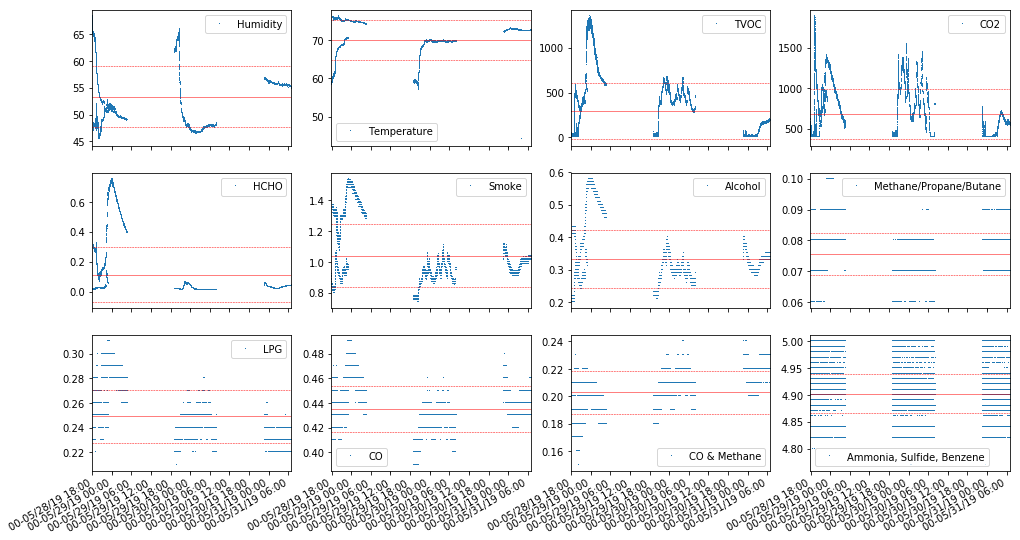

In [42]:
march.suite.SuitePlot()